<a href="https://colab.research.google.com/github/jhermosillo/keyword_extraction/blob/main/API_TextRank_GFractal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Módulos necesarios

In [ ]:
# !pip install deplacy
# !pip install spacy

In [ ]:
# !python -m spacy download en_core_web_sm
# !python -m spacy download es_core_news_sm

In [2]:
!pip install scoring

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pkg_resources,imp
imp.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.7/dist-packages/pkg_resources/__init__.py'>

### Librerías necesarias para los algoritmos

In [4]:
from math import *
from math import sqrt
import string
import operator
import random
import pandas as pd
#librerias necesarias para text rank
from collections import OrderedDict
import numpy as np
import spacy

#Listado de STOPWORDS dependiendo del lenguaje
from spacy.lang.en.stop_words import STOP_WORDS
#from spacy.lang.es.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm')
#nlp = spacy.load('es_core_news_sm')

In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import InputLayer,Dense,Dropout
from tensorflow.keras.layers import BatchNormalization
from keras.regularizers import l1,l1_l2,l2
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import RMSprop
from keras.layers.advanced_activations import LeakyReLU

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
    

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

from scoring import *

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Algoritmo TextRank

In [6]:
class TextRank4Keyword():
    """Extract keywords from text"""

    def __init__(self):
        self.d = 0.85 # damping coefficient, usually is .85
        self.min_diff = 1e-5 # convergence threshold
        self.steps = 100 # iteration steps
        self.node_weight = None # save keywords and its weight

    
    def set_stopwords(self, stopwords):  
        """Set stop words"""
        for word in STOP_WORDS.union(set(stopwords)):
            lexeme = nlp.vocab[word]
            lexeme.is_stop = True
    
    def sentence_segment(self, doc, candidate_pos, lower):
        """Store those words only in cadidate_pos"""
        sentences = []
        for sent in doc.sents:
            selected_words = []
            for token in sent:
                # Store words only with cadidate POS tag
                if token.pos_ in candidate_pos and token.is_stop is False:
                    if lower is True:
                        selected_words.append(token.text.lower())
                    else:
                        selected_words.append(token.text)
            sentences.append(selected_words)
        return sentences
        
    def get_vocab(self, sentences):
        """Get all tokens"""
        vocab = OrderedDict()
        i = 0
        for sentence in sentences:
            for word in sentence:
                if word not in vocab:
                    vocab[word] = i
                    i += 1
        return vocab
    
    def get_token_pairs(self, window_size, sentences):
        """Build token_pairs from windows in sentences"""
        token_pairs = list()
        for sentence in sentences:
            for i, word in enumerate(sentence):
                for j in range(i+1, i+window_size):
                    if j >= len(sentence):
                        break
                    pair = (word, sentence[j])
                    if pair not in token_pairs:
                        token_pairs.append(pair)
        return token_pairs
        
    def symmetrize(self, a):
        return a + a.T - np.diag(a.diagonal())
    
    def get_matrix(self, vocab, token_pairs):
        """Get normalized matrix"""
        # Build matrix
        vocab_size = len(vocab)
        g = np.zeros((vocab_size, vocab_size), dtype='float')
        for word1, word2 in token_pairs:
            i, j = vocab[word1], vocab[word2]
            g[i][j] = 1
            
        # Get Symmeric matrix
        g = self.symmetrize(g)
        
        # Normalize matrix by column
        norm = np.sum(g, axis=0)
        g_norm = np.divide(g, norm, where=norm!=0) # this is ignore the 0 element in norm
        
        return g_norm

    
    def get_keywords(self, number=10):
        """Print top number keywords"""
        keysw={}
        node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))
        for i, (key, value) in enumerate(node_weight.items()):
            keysw[key] =value
            if i > number:
                break
        return keysw
        
        
    def analyze(self, text, 
                candidate_pos=['NOUN', 'PROPN'], 
                window_size=4, lower=False, stopwords=list()):
        """Main function to analyze text"""
        
        # Set stop words
        self.set_stopwords(stopwords)
        
        # Pare text by spaCy
        doc = nlp(text)
        
        # Filter sentences
        sentences = self.sentence_segment(doc, candidate_pos, lower) # list of list of words
        
        # Build vocabulary
        vocab = self.get_vocab(sentences)
        
        # Get token_pairs from windows
        token_pairs = self.get_token_pairs(window_size, sentences)
        
        # Get normalized matrix
        g = self.get_matrix(vocab, token_pairs)
        
        # Initionlization for weight(pagerank value)
        pr = np.array([1] * len(vocab))
        
        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr = (1-self.d) + self.d * np.dot(g, pr)
            if abs(previous_pr - sum(pr))  < self.min_diff:
                break
            else:
                previous_pr = sum(pr)

        # Get weight for each node
        node_weight = dict()
        for word, index in vocab.items():
            node_weight[word] = pr[index]
        
        self.node_weight = node_weight
        

# Algoritmo Grado de Fractalidad

In [7]:
#solamente se calcula el grado de fractalidad de las palabras que tengan mas de uno de frecuencia
def fractalidad(palabras,vocabulario,frec,dist):
    N=len(palabras)                                     #El número de tokens de todo el texto
    gf={}
    cajas_index=set()
    voc=[]                                             #la variable voc contendra cada sintagma con frecuencia mayor que 1, por que las otras palabras tendrán 0 de grado de fractaldiad
    for p in vocabulario:                              #Esto se puede hacer fuera del algoritmo, pero se incluye para evitar ese calculo innecesario 
        if(p not in voc):
            if(frec[p]>1):
                if(p not in STOP_WORDS):
                    if(len(p)>1):
                        voc.append(p)
    # print("Text size: ",N)
    # print("Vocabulary: ",len(voc))
    for p in voc:                                  
        rcajas=dist[p]
        M=frec[p]                                  
        dfw=0.0
        nsh=0.0
        for s in range(1,N+1):  
            noc=0                                       
            for e in rcajas:                       
                cajas_index.add(ceil(int(e)/s))    
            noc=len(cajas_index)                    
            cajas_index.clear()    
            ns=N/s
            if(M<=ns):
                nsh=M
            else:
                nsh=M/(1+(M-1)/(N-1)*(s-1)) 
            dfw=dfw+fabs(log(nsh/noc))
        gf[p]=dfw
    return gf    #regresamos un diccionario

In [8]:
def distribucion(palabras,vocabulario):
    N=len(palabras)
    ncajas=[]
    cajas={}
    frecuencias={}
    for p in vocabulario:
        ncajas.clear()
        i=0
        M=palabras.count(p)
        while(i<N):
            if(p == palabras[i]):
                ncajas.append(i+1)
            i=i+1
        frecuencias[p]=M
        cajas[p]=ncajas[:]
    return frecuencias,cajas

# Lectura de archivo de entrada

In [9]:
#Lectura de archivo para generación de vocabulario
def cargar_datos(filename):
    f=open(filename, "r") #tenemos que crear un directorio llamado InputData
    texto=f.read()
    #Pasar a minusculas
    texto=texto.lower()
    #Eliminar puntuación
    texto=texto.translate(str.maketrans('', '', string.punctuation))
    texto=texto.translate(str.maketrans('', '', '¿¡—“”0123456789’'))
    palabras=texto.split()
    textop=""
    #rearmamos el texto debido a ue existen carácteres especiales
    for w in palabras:
        textop=textop+w+' '
    return textop

DEFINICIÓN DEL NOMBRE DEL ARCHIVO A PROCESAR

Lectura de documentos

In [10]:
def lee_documento(filename='NULL',texto=''):
    if filename != 'NULL':
        texto=cargar_datos(filename)
    #obtenemos el vocabulario
    tokens=texto.split()
    vocabulario=[]
    for t in tokens:
        if(t not in vocabulario):
            vocabulario.append(t)
    #variables de procesamiento
    dist={}
    frec={}
    frec,dist=distribucion(tokens,vocabulario)
    return frec,dist,tokens,vocabulario,texto

# Ejecución de algoritmos y generación de archivos de salida

In [11]:
# lectura de documento de prueba
frec,dist,tokens,vocabulario,texto = lee_documento('data.txt')

## Grado de Fractalidad

In [12]:
#ejecución de algoritmo Grado de Fractalidad
def grado_de_fractalidad(tokens,vocabulario,frec,dist,regresa_kw=False,regresa_df=True,top_n=np.inf,escribe_arch=False):
    frac_x=fractalidad(tokens,vocabulario,frec,dist) 
    sorted_x = sorted(frac_x.items(), key=operator.itemgetter(1), reverse=True)
    # print('Time GF: '+str(elapsed_time))

    #Imprimir y guardar resultados de GF
    if regresa_df:
        if top_n != np.inf:
            df=[[t[0],frec[t[0]], t[1], t[1]*log10(frec[t[0]])] for t in sorted_x[:top_n]]
        else:
            df=[[t[0],frec[t[0]], t[1], t[1]*log10(frec[t[0]])] for t in sorted_x]
        #Ordenar resultados por medida combinada
        df.sort(key=lambda x: x[3],reverse=True)
        if regresa_kw==False:
            df = [dato[0] for dato in df]
            by_MC=pd.DataFrame(df, columns=['word'])
        else:   
            by_MC=pd.DataFrame(df, columns=['word','frecuency','Degree_of_fractality','Combined_measure'])
        if escribe_arch:
            by_MC.to_csv('GF.csv')
    else:
        if top_n != np.inf:
            df=[[t[0],frec[t[0]], t[1], t[1]*log10(frec[t[0]])] for t in sorted_x[:top_n]]
        else:
            df=[[t[0],frec[t[0]], t[1], t[1]*log10(frec[t[0]])] for t in sorted_x]
        #Ordenar resultados por medida combinada
        df.sort(key=lambda x: x[3],reverse=True)
        if regresa_kw==False:
            by_MC = [dato[0] for dato in df]
        else:
            by_MC = df
        if escribe_arch:
            print('\nNo se tiene implementada la escritura de archivo cuando regresa_df==False\n')
    return by_MC

def use_gf(texto,regresa_kw=False,regresa_df=False,top_n=np.inf,escribe_arch=False):
    tokens=texto.split()
    vocabulario=[]
    for t in tokens:
        if(t not in vocabulario):
            vocabulario.append(t)
    #variables de procesamiento
    dist={}
    frec={}
    frec,dist=distribucion(tokens,vocabulario)
    df = grado_de_fractalidad(tokens,vocabulario,frec,dist,regresa_kw,regresa_df,top_n,escribe_arch)
    return df

df1 = use_gf(texto,regresa_kw=True,regresa_df=True,top_n=10)
df1

,word,frecuency,Degree_of_fractality,Combined_measure
0,latin,4,167.127394,100.620717
1,content,3,205.903714,98.241038
2,humour,3,163.880039,78.190650
3,injected,3,163.200270,77.866318
4,dummy,2,191.726724,57.715495
5,type,2,191.726724,57.715495
6,line,2,179.412131,54.008433
7,internet,2,175.612973,52.864773
8,reproduced,2,169.604962,51.056181
9,typesetting,2,166.080279,49.995146


## TextRank

In [13]:
#ejecución de algoritmo de TextRank
# start_time = time()
def use_TextRank(texto,regresa_kw=False,regresa_df=False,top_n=np.inf,escribe_arch=False):
    tr4w = TextRank4Keyword()
    tr4w.analyze(texto, candidate_pos = ['NOUN','PROPN'], window_size=4, lower=False)
    kwTR=tr4w.get_keywords(100)

    #Guardar resultados de TextRank
    if regresa_df:
        if top_n!=np.inf:
            if regresa_kw==True:
                salida = [[key, kwTR[key]] for key in kwTR.keys()][:top_n]
                dftr=pd.DataFrame(salida, columns=['word', 'Index'])
            else:
                salida = list(kwTR.keys())[:top_n]
                dftr=pd.DataFrame(salida, columns=['word'])
        else:
            if regresa_kw==True:
                salida = [[key, kwTR[key]] for key in kwTR.keys()]
                dftr=pd.DataFrame(salida, columns=['word', 'Index'])
            else:
                salida = list(kwTR.keys())
                dftr=pd.DataFrame(salida, columns=['word'])
    else:
        if top_n!=np.inf:
            if regresa_kw==True:
                dftr = [[key, kwTR[key]] for key in kwTR.keys()][:top_n]
            else:
                dftr = list(kwTR.keys())[:top_n]
        else:
            if regresa_kw==True:
                dftr = [[key, kwTR[key]] for key in kwTR.keys()]
            else:
                dftr = list(kwTR.keys())
        # elapsed_time = time() - start_time
        # print('Time TextRank: '+str(elapsed_time))
        if escribe_arch:
            dftr.to_csv('TextRank.csv')
    return dftr

dftr = use_TextRank(texto,top_n=10)
dftr

['ipsum',
 'lorem',
 'versions',
 'words',
 'text',
 's',
 'content',
 'page',
 'model',
 'form']

# 20 Newsgroups

In [14]:
def preprocess_text(r,remove_STW=True,lemmatize=False):
    def check_STW(palabras):
        texto = [w for w in palabras \
                 if not w in STOP_WORDS and len(w)>2]
        return texto
    def remove_basura(palabras):
        basura = pd.read_csv('basura.txt',sep='\n',names=['words'])
        basura = basura.words.tolist()
        texto = [w for w in palabras if not w in basura]
        return texto        
    r1=r.cadena.str.translate(\
          str.maketrans('','',string.digits))\
          .str.translate(\
          str.maketrans('','',string.punctuation))\
          .str.replace('«','', regex=True)\
          .str.replace('»','', regex=True).str.replace('(','', regex=True)\
          .str.replace('\n',' ', regex=True)\
          .str.replace(')','', regex=True).str.strip().str.lower()
    if remove_STW:
        r1=r1.to_frame().applymap(lambda x : x.split()).applymap(check_STW).applymap(lambda x: ' '.join(x))
        r1=r1.applymap(lambda x : x.split()).applymap(remove_basura).applymap(lambda x: ' '.join(x))
    if lemmatize:
        if isinstance(r1, pd.DataFrame):
            r1=r1.applymap(lambda x : nlp(x)).applymap(lambda x: ' '.join([token.lemma_ for token in x]))        
        else:
            r1=r1.to_frame().applymap(lambda x : nlp(x)).applymap(lambda x: ' '.join([token.lemma_ for token in x]))        
    r.cadena = r1
    r=r.rename(columns={'cadena':'docs'})
    return r

In [15]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train',remove=('headers', 'footers', 'quotes'))

from pprint import pprint
# pprint(list(newsgroups_train.target_names))

cats=list(newsgroups_train.target_names)
n = len(cats)//2
cats1=cats[:n]
cats2=cats[n:]
# print(cats)
print(cats1)
print(cats2)
categories = [cats1,cats2]

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball']
['rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [31]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

with open('basura.txt') as f:
    palabras = f.readlines()

print(len(palabras))
# basura=[]
# for w in palabras:
#   if not wordnet.synsets(w.strip()):
#     basura.append(w)
# file = open('basura.txt','w')
# file.writelines(basura)
# file.close()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
7023


In [33]:
def process_20NG(categories,n=20,th=5,remove_STW=True,lemmatize=False):
    data=[]
    for i,cats in enumerate(categories):
        newsgroups_train = fetch_20newsgroups(subset='train', 
                                        remove=('headers', 'footers', 'quotes'),
                                        categories=cats)
        df = pd.DataFrame(newsgroups_train.data, columns=['cadena'])
        df['target'] = pd.Series(newsgroups_train.target+len(cats)*i)
        df = preprocess_text(df,remove_STW=remove_STW,lemmatize=lemmatize)
        df['TR'] = df.docs.apply(lambda x : use_TextRank(x,top_n=n))
        df['GF'] = df.docs.apply(lambda x : use_gf(x,top_n=n))
        df=df.drop(df[df.TR.apply(lambda x: len(x)<th)].index).reset_index(drop=True)
        df=df.drop(df[df.GF.apply(lambda x: len(x)<th)].index).reset_index(drop=True)
        data.append(df)
    lista=range(len(categories))
    newsgroups_data = data[0]
    if len(lista)>1:
        for j in lista[1:]:
            newsgroups_data = newsgroups_data.append(data[j],ignore_index=True)
    newsgroups_data = newsgroups_data.sample(frac=1).reset_index(drop=True)
    # newsgroups_data.to_csv('newsgroups_train_data.csv')
    return newsgroups_data

In [57]:
newsgroups_train_data = process_20NG(categories,n=100,remove_STW=True)
newsgroups_train_data

,docs,target,TR,GF
0,archivename spacedata lastmodified date online...,14,"[data, nasa, information, ftp, directory, cont...","[catalogue, maps, starchart, sheets, volume, m..."
1,arethe numbers stating past messages angers in...,7,"[car, numbers, figures, sentra, run, del, sol,...","[according, sentra, run, figures, dont, come, ..."
2,merely start working yellowcake devise system ...,16,"[physics, laws, reactors, sources, device, cre...","[physics, sources, reactors, merely, thats, la..."
3,curious thing stuiiis nsadesigned secure telep...,11,"[traffic, phones, word, agencies, enforcement,...","[stuiiis, need, compatible, phones, theyre, tr..."
4,hello remember running macuserworld years ago ...,4,"[board, simms, talking, business, ram, disk, s...","[know, simms, board, like, remember]"
...,...,...,...,...
4705,theres lot whining players overpaid thought un...,9,"[thomas, players, player, team, lot, bagwell, ...","[players, thomas, team, bagwell, million, lot,..."
4706,require separate grounds ground goes ground pi...,12,"[ground, metal, grounds, wolf, christopher, so...","[ground, faceplate, metal, connected, grounds]"
4707,mind recently purchased gcc blp elite like nee...,4,"[paper, sheet, mathematics, department, calvin...","[sheet, paper, feeder, feed, gcc]"
4708,survived mailed postings things didnt know thi...,16,"[norway, fbi, censor, text, places, batf, waco...","[norway, trying, went, doesnt, censor, fbi]"


In [76]:
df1 = newsgroups_train_data.copy()
df1

,docs,target,TR,GF
0,archivename spacedata lastmodified date online...,14,"[data, nasa, information, ftp, directory, cont...","[catalogue, maps, starchart, sheets, volume, m..."
1,arethe numbers stating past messages angers in...,7,"[car, numbers, figures, sentra, run, del, sol,...","[according, sentra, run, figures, dont, come, ..."
2,merely start working yellowcake devise system ...,16,"[physics, laws, reactors, sources, device, cre...","[physics, sources, reactors, merely, thats, la..."
3,curious thing stuiiis nsadesigned secure telep...,11,"[traffic, phones, word, agencies, enforcement,...","[stuiiis, need, compatible, phones, theyre, tr..."
4,hello remember running macuserworld years ago ...,4,"[board, simms, talking, business, ram, disk, s...","[know, simms, board, like, remember]"
...,...,...,...,...
4705,theres lot whining players overpaid thought un...,9,"[thomas, players, player, team, lot, bagwell, ...","[players, thomas, team, bagwell, million, lot,..."
4706,require separate grounds ground goes ground pi...,12,"[ground, metal, grounds, wolf, christopher, so...","[ground, faceplate, metal, connected, grounds]"
4707,mind recently purchased gcc blp elite like nee...,4,"[paper, sheet, mathematics, department, calvin...","[sheet, paper, feeder, feed, gcc]"
4708,survived mailed postings things didnt know thi...,16,"[norway, fbi, censor, text, places, batf, waco...","[norway, trying, went, doesnt, censor, fbi]"


In [77]:
df1['TR']=df1['TR'].apply(lambda x: tuple(x))
df1['GF']=df1['GF'].apply(lambda x: tuple(x))
df1

,docs,target,TR,GF
0,archivename spacedata lastmodified date online...,14,"(data, nasa, information, ftp, directory, cont...","(catalogue, maps, starchart, sheets, volume, m..."
1,arethe numbers stating past messages angers in...,7,"(car, numbers, figures, sentra, run, del, sol,...","(according, sentra, run, figures, dont, come, ..."
2,merely start working yellowcake devise system ...,16,"(physics, laws, reactors, sources, device, cre...","(physics, sources, reactors, merely, thats, la..."
3,curious thing stuiiis nsadesigned secure telep...,11,"(traffic, phones, word, agencies, enforcement,...","(stuiiis, need, compatible, phones, theyre, tr..."
4,hello remember running macuserworld years ago ...,4,"(board, simms, talking, business, ram, disk, s...","(know, simms, board, like, remember)"
...,...,...,...,...
4705,theres lot whining players overpaid thought un...,9,"(thomas, players, player, team, lot, bagwell, ...","(players, thomas, team, bagwell, million, lot,..."
4706,require separate grounds ground goes ground pi...,12,"(ground, metal, grounds, wolf, christopher, so...","(ground, faceplate, metal, connected, grounds)"
4707,mind recently purchased gcc blp elite like nee...,4,"(paper, sheet, mathematics, department, calvin...","(sheet, paper, feeder, feed, gcc)"
4708,survived mailed postings things didnt know thi...,16,"(norway, fbi, censor, text, places, batf, waco...","(norway, trying, went, doesnt, censor, fbi)"


In [79]:

df1['TR'] = df1['TR'].astype('category')
df1['GF'] = df1['GF'].astype('category')
df1.dtypes

docs        object
target       int64
TR        category
GF        category
dtype: object

In [81]:
df1

,docs,target,TR,GF
0,archivename spacedata lastmodified date online...,14,"(data, nasa, information, ftp, directory, cont...","(catalogue, maps, starchart, sheets, volume, m..."
1,arethe numbers stating past messages angers in...,7,"(car, numbers, figures, sentra, run, del, sol,...","(according, sentra, run, figures, dont, come, ..."
2,merely start working yellowcake devise system ...,16,"(physics, laws, reactors, sources, device, cre...","(physics, sources, reactors, merely, thats, la..."
3,curious thing stuiiis nsadesigned secure telep...,11,"(traffic, phones, word, agencies, enforcement,...","(stuiiis, need, compatible, phones, theyre, tr..."
4,hello remember running macuserworld years ago ...,4,"(board, simms, talking, business, ram, disk, s...","(know, simms, board, like, remember)"
...,...,...,...,...
4705,theres lot whining players overpaid thought un...,9,"(thomas, players, player, team, lot, bagwell, ...","(players, thomas, team, bagwell, million, lot,..."
4706,require separate grounds ground goes ground pi...,12,"(ground, metal, grounds, wolf, christopher, so...","(ground, faceplate, metal, connected, grounds)"
4707,mind recently purchased gcc blp elite like nee...,4,"(paper, sheet, mathematics, department, calvin...","(sheet, paper, feeder, feed, gcc)"
4708,survived mailed postings things didnt know thi...,16,"(norway, fbi, censor, text, places, batf, waco...","(norway, trying, went, doesnt, censor, fbi)"


In [84]:
df1.to_csv('newsgroups_train_data.csv', sep=',')

In [90]:
df = pd.read_csv ('newsgroups_train_data.csv',index_col=0)
df

,docs,target,TR,GF
0,archivename spacedata lastmodified date online...,14,"('data', 'nasa', 'information', 'ftp', 'direct...","('catalogue', 'maps', 'starchart', 'sheets', '..."
1,arethe numbers stating past messages angers in...,7,"('car', 'numbers', 'figures', 'sentra', 'run',...","('according', 'sentra', 'run', 'figures', 'don..."
2,merely start working yellowcake devise system ...,16,"('physics', 'laws', 'reactors', 'sources', 'de...","('physics', 'sources', 'reactors', 'merely', '..."
3,curious thing stuiiis nsadesigned secure telep...,11,"('traffic', 'phones', 'word', 'agencies', 'enf...","('stuiiis', 'need', 'compatible', 'phones', 't..."
4,hello remember running macuserworld years ago ...,4,"('board', 'simms', 'talking', 'business', 'ram...","('know', 'simms', 'board', 'like', 'remember')"
...,...,...,...,...
4705,theres lot whining players overpaid thought un...,9,"('thomas', 'players', 'player', 'team', 'lot',...","('players', 'thomas', 'team', 'bagwell', 'mill..."
4706,require separate grounds ground goes ground pi...,12,"('ground', 'metal', 'grounds', 'wolf', 'christ...","('ground', 'faceplate', 'metal', 'connected', ..."
4707,mind recently purchased gcc blp elite like nee...,4,"('paper', 'sheet', 'mathematics', 'department'...","('sheet', 'paper', 'feeder', 'feed', 'gcc')"
4708,survived mailed postings things didnt know thi...,16,"('norway', 'fbi', 'censor', 'text', 'places', ...","('norway', 'trying', 'went', 'doesnt', 'censor..."


In [ ]:
df.groupby('target').apply(lambda x: )

In [ ]:
print(np.unique(newsgroups_train_data.target))
print(newsgroups_train_data.GF.values[:5])
print(newsgroups_train_data.TR.values[:5])
df = newsgroups_train_data.copy()
df

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[list(['fpu', 'mhz', 'clock', 'fine', 'work'])
 list(['clutch', 'alomar', 'baerga', 'rbis', 'hit', 'position', 'scoring', 'runner'])
 list(['motif', 'write', 'list', 'widget', 'need', 'header', 'multicolumn', 'probably'])
 list(['know', 'jesuss', 'father', 'jesus', 'king', 'earthly', 'people', 'plea', 'come', 'death', 'kingdom', 'joh', 'garden', 'presense', 'suffer', 'pass', 'believe'])
 list(['celp', 'week', 'sparc', 'think', 'end', 'sun', 'bps', 'coder', 'code', 'source'])]
[list(['mhz', 'work', 'fpu', 'clock', 'midget', 'coprocessor', 'label', 'racer', 'system', 'cpu', 'math', 'chip', 'xcrc', 'stefan'])
 list(['baerga', 'alomar', 'scoring', 'position', 'clutch', 'rbis', 'time', 'batter', 'year', 'situation', 'bat', 'runner', 'difference', 'vote', 'chance', 'word', 'mvp'])
 list(['motif', 'widget', 'list', 'multicolumn', 'header', 'spec', 'answer', 'chance', 'lot', 'save', 'sell', 'code', 'context', 'platform', 'file', 'ap

,docs,target,TR,GF
0,xcrc math coprocessor instal succesfully mega ...,12,"[mhz, work, fpu, clock, midget, coprocessor, l...","[fpu, mhz, clock, fine, work]"
1,hope somebody mention clutch clutch baerga wor...,9,"[baerga, alomar, scoring, position, clutch, rb...","[clutch, alomar, baerga, rbis, hit, position, ..."
2,information need probably write new motif widg...,5,"[motif, widget, list, multicolumn, header, spe...","[motif, write, list, widget, need, header, mul..."
3,assume jesuss plea father let cup pass merely ...,15,"[jesus, father, people, king, jesuss, kingdom,...","[know, jesuss, father, jesus, king, earthly, p..."
4,forward old posting celp speech compression ca...,11,"[celp, sparc, week, sun, code, end, bps, sourc...","[celp, week, sparc, think, end, sun, bps, code..."
...,...,...,...,...
4911,fete word formally commonly refer positivejoyo...,17,"[policy, israel, solution, law, abhor, attitud...","[solution, final, israel, right, policy, israe..."
4912,white house office press secretary immediate r...,18,"[job, pittsburgh, press, april, saturday, pres...","[pittsburgh, job, press, secretary, april, hou..."
4913,bcs objectwindow version try datum process win...,2,"[program, window, object, mywindow, datum, pro...","[mywindow, program, mywinobj, window, object, ..."
4914,correction hard atheism faith grip man stalin ...,0,"[atheism, statement, people, faith, atheist, s...","[hard, statement, atheism, atheist, example, p..."


In [ ]:
newsgroups_train_data.to_pickle('newsgroups_train_data_sinSW_lemma_Top100.pickle')

## Lectura de archivo procesado

In [ ]:
df = pd.read_pickle('newsgroups_train_data_sinSW_lemma_Top100.pickle')
df

,docs,target,TR,GF
0,xcrc math coprocessor instal succesfully mega ...,12,"[mhz, work, fpu, clock, midget, coprocessor, l...","[fpu, mhz, clock, fine, work]"
1,hope somebody mention clutch clutch baerga wor...,9,"[baerga, alomar, scoring, position, clutch, rb...","[clutch, alomar, baerga, rbis, hit, position, ..."
2,information need probably write new motif widg...,5,"[motif, widget, list, multicolumn, header, spe...","[motif, write, list, widget, need, header, mul..."
3,assume jesuss plea father let cup pass merely ...,15,"[jesus, father, people, king, jesuss, kingdom,...","[know, jesuss, father, jesus, king, earthly, p..."
4,forward old posting celp speech compression ca...,11,"[celp, sparc, week, sun, code, end, bps, sourc...","[celp, week, sparc, think, end, sun, bps, code..."
...,...,...,...,...
4911,fete word formally commonly refer positivejoyo...,17,"[policy, israel, solution, law, abhor, attitud...","[solution, final, israel, right, policy, israe..."
4912,white house office press secretary immediate r...,18,"[job, pittsburgh, press, april, saturday, pres...","[pittsburgh, job, press, secretary, april, hou..."
4913,bcs objectwindow version try datum process win...,2,"[program, window, object, mywindow, datum, pro...","[mywindow, program, mywinobj, window, object, ..."
4914,correction hard atheism faith grip man stalin ...,0,"[atheism, statement, people, faith, atheist, s...","[hard, statement, atheism, atheist, example, p..."


In [ ]:
df = df.drop(df[df.TR.apply(lambda x: len(x)<5)].index).reset_index(drop=True)
df = df.drop(df[df.GF.apply(lambda x: len(x)<5)].index).reset_index(drop=True)
df

,docs,target,TR,GF
0,xcrc math coprocessor instal succesfully mega ...,12,"[mhz, work, fpu, clock, midget, coprocessor, l...","[fpu, mhz, clock, fine, work]"
1,hope somebody mention clutch clutch baerga wor...,9,"[baerga, alomar, scoring, position, clutch, rb...","[clutch, alomar, baerga, rbis, hit, position, ..."
2,information need probably write new motif widg...,5,"[motif, widget, list, multicolumn, header, spe...","[motif, write, list, widget, need, header, mul..."
3,assume jesuss plea father let cup pass merely ...,15,"[jesus, father, people, king, jesuss, kingdom,...","[know, jesuss, father, jesus, king, earthly, p..."
4,forward old posting celp speech compression ca...,11,"[celp, sparc, week, sun, code, end, bps, sourc...","[celp, week, sparc, think, end, sun, bps, code..."
...,...,...,...,...
4911,fete word formally commonly refer positivejoyo...,17,"[policy, israel, solution, law, abhor, attitud...","[solution, final, israel, right, policy, israe..."
4912,white house office press secretary immediate r...,18,"[job, pittsburgh, press, april, saturday, pres...","[pittsburgh, job, press, secretary, april, hou..."
4913,bcs objectwindow version try datum process win...,2,"[program, window, object, mywindow, datum, pro...","[mywindow, program, mywinobj, window, object, ..."
4914,correction hard atheism faith grip man stalin ...,0,"[atheism, statement, people, faith, atheist, s...","[hard, statement, atheism, atheist, example, p..."


# Distribución del vocabulario

In [ ]:
from nltk.tokenize import word_tokenize

textos = df['TR'].values.tolist()
t = ' '.join(textos[0])
for l in textos[1:]:
    t += ' '.join(l)
vocTR = set(word_tokenize(t))
print(len(vocTR),'palabras únicas (tipos)')

37518 palabras únicas (tipos)


In [ ]:
textos = df['GF'].values.tolist()
t = ' '.join(textos[0])
for l in textos[1:]:
    t += ' '.join(l)
vocGF = set(word_tokenize(t))
print(len(vocGF),'palabras únicas (tipos)')

18401 palabras únicas (tipos)


In [ ]:
basura = []
for w in vocTR:
    if len(w) > 12:
        basura.append(w)
TRvoc = []
for w in vocTR:
    if w not in basura:
        TRvoc.append(w)
print(len(TRvoc))
np.savetxt('basura_TR.txt',basura,fmt = '%s',delimiter=',')

32035


In [ ]:
basura = []
for w in vocGF:
    if len(w) > 12:
        basura.append(w)
GFvoc = []
for w in vocGF:
    if w not in basura:
        GFvoc.append(w)
print(len(GFvoc))
np.savetxt('basura_GF.txt',basura,fmt = '%s',delimiter=',')

16227


In [ ]:
basura_TR = pd.read_csv('basura_TR.txt',sep='\n',names=['words'])
basura_GF = pd.read_csv('basura_GF.txt',sep='\n',names=['words'])
basura = pd.concat([basura_TR,basura_GF])
basura = basura.words.tolist()

np.savetxt('basura.txt',basura,fmt = '%s',delimiter=',')

In [ ]:
vocINTER = list(set(TRvoc).intersection(set(GFvoc)))
print(len(vocINTER))

11058


# Word2vec

In [ ]:
# import modules & set up logging
from gensim.models import Word2Vec as w2v
import gensim.downloader as api

def vocdf(df,vec_size=100):
    # obtain vocabulary word types 
    types=df['docs'].str.split(' ', expand=True).stack().unique()
    # Data Frame of vocabulary and word embeddings
    typesDF=pd.Series(types).to_frame()
    typesDF.rename(index=int,columns={0:'Palabra'},inplace=True)

    #Add Emebddings placeholders
    #Se necesita convertir el DF a diccionario
    #luego se agregan vectores de dimension N,
    #como registros nuevos del diccionario
    #para reconvertirlo en un DF de vuelta
    dico=typesDF.to_dict('records',into=OrderedDict)
    #Add real-valued embedding vectors
    for reg in dico:
        reg['W2V']=np.zeros(vec_size)
    typesDF=pd.DataFrame.from_dict(dico)
    typesDF.set_index('Palabra',inplace=True)
    return typesDF

def compute_embeddings(df,typesdf,vec_dim=100):
    #Nos quedamos con la columna que nos importa, la que contiene las cadenas
    docs = df["docs"].values.tolist()
    docs = [s.split() for s in docs]
    model = w2v(docs, min_count=1, vector_size=vec_dim)
    words = typesdf.index.values.tolist()
    for w in words:
        typesdf.at[w,'W2V'] = model.wv[w]
    return

typesDF = vocdf(df)
print(typesDF.iloc[0].W2V.shape)

compute_embeddings(df,typesDF)
print(typesDF.loc['sound'])
typesDF.to_pickle('typesDF_WE.pickle')
typesDF.head()
# model.wv['sound']
# model.wv.most_similar('good', topn=10) 

(100,)
W2V    [-0.69282186, 1.7486495, -0.21840484, 0.781423...
Name: sound, dtype: object


,W2V
Palabra,
xcrc,"[0.0014066594, 0.034520324, -0.017739989, -0.0..."
math,"[-0.07129391, 0.38176948, 0.03139225, -0.23337..."
coprocessor,"[-0.05900353, 0.24258842, -0.014908521, -0.161..."
instal,"[-0.44508687, 1.1838291, -0.111255884, -0.8382..."
succesfully,"[0.00038468733, 0.045200463, 0.013040284, -0.0..."


In [ ]:
typesDF = pd.read_pickle('typesDF_WE.pickle')
typesDF.head()

,W2V
Palabra,
xcrc,"[0.0014066594, 0.034520324, -0.017739989, -0.0..."
math,"[-0.07129391, 0.38176948, 0.03139225, -0.23337..."
coprocessor,"[-0.05900353, 0.24258842, -0.014908521, -0.161..."
instal,"[-0.44508687, 1.1838291, -0.111255884, -0.8382..."
succesfully,"[0.00038468733, 0.045200463, 0.013040284, -0.0..."


# Construye los arreglos de features

In [ ]:
df['VTR'] = df.TR.apply(lambda x: np.array([vec for word in x for vec in typesDF.loc[word]]))
df.head()

,docs,target,TR,GF,VTR
0,xcrc math coprocessor instal succesfully mega ...,12,"[mhz, work, fpu, clock, midget, coprocessor, l...","[fpu, mhz, clock, fine, work]","[[-0.23647325, 1.2871871, -0.09720891, -1.0907..."
1,hope somebody mention clutch clutch baerga wor...,9,"[baerga, alomar, scoring, position, clutch, rb...","[clutch, alomar, baerga, rbis, hit, position, ...","[[-0.010285099, 0.26223862, 0.07560293, 0.1424..."
2,information need probably write new motif widg...,5,"[motif, widget, list, multicolumn, header, spe...","[motif, write, list, widget, need, header, mul...","[[-0.4410229, 1.419313, -0.051532116, -1.72070..."
3,assume jesuss plea father let cup pass merely ...,15,"[jesus, father, people, king, jesuss, kingdom,...","[know, jesuss, father, jesus, king, earthly, p...","[[-0.8205729, 0.87583417, 1.7917535, 1.9580623..."
4,forward old posting celp speech compression ca...,11,"[celp, sparc, week, sun, code, end, bps, sourc...","[celp, week, sparc, think, end, sun, bps, code...","[[-0.010959696, 0.18030845, 0.024353385, -0.20..."


In [ ]:
df['VGF'] = df.GF.apply(lambda x: np.array([vec for word in x for vec in typesDF.loc[word]]))
df.head()

,docs,target,TR,GF,VTR,VGF
0,xcrc math coprocessor instal succesfully mega ...,12,"[mhz, work, fpu, clock, midget, coprocessor, l...","[fpu, mhz, clock, fine, work]","[[-0.23647325, 1.2871871, -0.09720891, -1.0907...","[[-0.09186578, 0.5321549, -0.00072048564, -0.2..."
1,hope somebody mention clutch clutch baerga wor...,9,"[baerga, alomar, scoring, position, clutch, rb...","[clutch, alomar, baerga, rbis, hit, position, ...","[[-0.010285099, 0.26223862, 0.07560293, 0.1424...","[[-0.0980663, 0.35770047, 0.077855, 0.09767955..."
2,information need probably write new motif widg...,5,"[motif, widget, list, multicolumn, header, spe...","[motif, write, list, widget, need, header, mul...","[[-0.4410229, 1.419313, -0.051532116, -1.72070...","[[-0.4410229, 1.419313, -0.051532116, -1.72070..."
3,assume jesuss plea father let cup pass merely ...,15,"[jesus, father, people, king, jesuss, kingdom,...","[know, jesuss, father, jesus, king, earthly, p...","[[-0.8205729, 0.87583417, 1.7917535, 1.9580623...","[[-0.7955314, 1.6058489, 0.5825205, 0.71473056..."
4,forward old posting celp speech compression ca...,11,"[celp, sparc, week, sun, code, end, bps, sourc...","[celp, week, sparc, think, end, sun, bps, code...","[[-0.010959696, 0.18030845, 0.024353385, -0.20...","[[-0.010959696, 0.18030845, 0.024353385, -0.20..."


In [ ]:
df.loc[df['target']==0]

,docs,target,TR,GF,VTR,VGF
13,spend bit time wording constitution pick word ...,0,"[word, constitution, imply, define, death, rel...","[word, dictionary, look, define, constitution]","[[-0.5977282, 0.6848841, 1.0444405, 0.75269806...","[[-0.5977282, 0.6848841, 1.0444405, 0.75269806..."
28,I ve provide example trend general provide one...,0,"[mating, goal, practice, trend, system, case, ...","[think, objective, system, natural, goal, prac...","[[-0.030552642, 0.03650063, 0.04261273, 0.0221...","[[-0.2564023, 1.6618041, 0.561814, 1.6431582, ..."
60,archivename atheismresource altatheismarchiven...,0,"[god, book, press, people, history, atheism, n...","[fish, book, london, darwin, germany, people, ...","[[-1.4118917, 1.0980778, 2.5379546, 2.040925, ...","[[-0.04236131, 0.27835277, 0.08320544, -0.0062..."
92,headpiece source newswire vatican home genetic...,0,"[bone, pope, gillow, vatican, transplant, tiss...","[pope, gillow, transplant, vatican, bone, expe...","[[-0.07421755, 0.3687042, 0.16790305, 0.028156...","[[-0.22923702, 0.43511385, 0.65174407, 0.49987..."
105,year I ve periodically ask charley wingate exp...,0,"[rationality, knowledge, basis, reason, repeat...","[reason, alternative, religious, knowledge, ra...","[[-0.032772277, 0.062282547, 0.07059663, 0.045...","[[-0.36881697, 0.8897087, 1.0077763, 1.4270301..."
...,...,...,...,...,...,...
4819,dollar can not answer question big bang theory...,0,"[theory, bang, dollar, big, cookie, question, ...","[answer, theory, big, bang, dollar]","[[-0.24977675, 0.744653, 0.72390574, 0.2305573...","[[-0.08943473, 0.5723217, 0.18112819, 0.361320..."
4873,look like folk loosened bit discuss topic bank...,0,"[science, koran, topic, book, islam, people, m...","[science, koran, topic, mention, islam, pretty...","[[-0.3963241, 0.45290017, 1.1826686, 0.1160386...","[[-0.3963241, 0.45290017, 1.1826686, 0.1160386..."
4901,disagree definition moral early say conscious ...,0,"[law, term, talk, morality, definition, behavi...","[moral, definition, silly, act, talk, law, con...","[[0.011456318, -0.3424748, 2.019903, 0.4418412...","[[-0.4965795, 0.3738158, 1.2962568, 0.694129, ..."
4902,mathew propose public defence mechanism treat ...,0,"[government, impropriety, device, mathew, just...","[offender, criminal, mathew, potential, propos...","[[0.3292683, 0.36231706, 0.81622726, 1.3739434...","[[-0.04776359, 0.13475959, 0.08712449, 0.02049..."


# Análisis de los términos TR y GF

In [ ]:
def get_voc_TR(df):
    textos = df['TR'].values.tolist()
    t = ' '.join(textos[0])
    for l in textos[1:]:
        t += ' '.join(l)
    voc = set(word_tokenize(t))
    return voc

def get_voc_GF(df):
    textos = df['GF'].values.tolist()
    t = ' '.join(textos[0])
    for l in textos[1:]:
        t += ' '.join(l)
    voc = set(word_tokenize(t))
    return voc

In [ ]:
vocTR=[]
for i in range(20):
    df1=df.loc[df['target']==i]
    voc = get_voc_TR(df1)
    vocTR.append(voc)
    
vocGF=[]
for i in range(20):
    df1=df.loc[df['target']==i]
    voc = get_voc_GF(df1)
    vocGF.append(voc)

In [ ]:
for v in vocTR:
    print(len(v),end=' ')
print('\n')
for v in vocGF:
    print(len(v),end=' ')

3213 3170 2798 2862 2524 3476 3964 3199 3139 3354 4193 4605 3553 4403 4460 5613 4168 5681 4138 3696 

1690 1690 1240 1402 1102 2011 1415 1335 1145 1363 1944 2354 1476 2453 2536 2618 2086 3037 2226 1840 

## Padding de arreglos

In [ ]:
def paddingX(X,n,vec_dim):
    pad_vec = np.zeros(vec_dim)
    for i,x in enumerate(X):
        if x[0].shape[0] != n:
            fn = n - x[0].shape[0]
            padx = x[0].tolist()
            for j in range(fn):
                padx.append(pad_vec)
            X[i][0]=np.array(padx)
        else:
            X[i][0]=x[0]
    return

def padding(X,n,vec_dim):
    pad_vec = np.zeros(vec_dim)
    newX = []
    for x in X:
        if x.shape[0] < n:
            fn = n - x.shape[0]
            padx = x.tolist()
            for j in range(fn):
                padx.append(pad_vec)
            newX.append(padx)
        else:
            newX.append(x[:n])
    return np.array(newX)

In [ ]:
X_VTR = df.VTR.values
X_VTR = X_VTR.reshape(X_VTR.shape[0],1)
y_VTR = df.target.values
y_VTR = y_VTR.reshape(y_VTR.shape[0],1)
VTR_train = np.hstack((X_VTR,y_VTR))
# padding(VTR_train,20,100)
VTR_train = pd.DataFrame(VTR_train,columns=['vec','target'])
VTR_train

,vec,target
0,"[[-0.23647325, 1.2871871, -0.09720891, -1.0907...",12
1,"[[-0.010285099, 0.26223862, 0.07560293, 0.1424...",9
2,"[[-0.4410229, 1.419313, -0.051532116, -1.72070...",5
3,"[[-0.8205729, 0.87583417, 1.7917535, 1.9580623...",15
4,"[[-0.010959696, 0.18030845, 0.024353385, -0.20...",11
...,...,...
4911,"[[0.05621279, 0.14795592, 0.8744687, 0.0961214...",17
4912,"[[-0.04250086, 1.5259048, -0.12256589, 1.07950...",18
4913,"[[-0.3321725, 1.505385, 0.10308443, -1.9169239...",2
4914,"[[-0.23063877, 0.24631108, 0.8137651, 0.482804...",0


In [ ]:
X_VGF = df.VTR.values
X_VGF = X_VGF.reshape(X_VGF.shape[0],1)
y_VGF = df.target.values
y_VGF = y_VGF.reshape(y_VGF.shape[0],1)
VGF_train = np.hstack((X_VGF,y_VGF))
# padding(VGF_train,20,100)
VGF_train = pd.DataFrame(VGF_train,columns=['vec','target'])
VGF_train

,vec,target
0,"[[-0.23647325, 1.2871871, -0.09720891, -1.0907...",12
1,"[[-0.010285099, 0.26223862, 0.07560293, 0.1424...",9
2,"[[-0.4410229, 1.419313, -0.051532116, -1.72070...",5
3,"[[-0.8205729, 0.87583417, 1.7917535, 1.9580623...",15
4,"[[-0.010959696, 0.18030845, 0.024353385, -0.20...",11
...,...,...
4911,"[[0.05621279, 0.14795592, 0.8744687, 0.0961214...",17
4912,"[[-0.04250086, 1.5259048, -0.12256589, 1.07950...",18
4913,"[[-0.3321725, 1.505385, 0.10308443, -1.9169239...",2
4914,"[[-0.23063877, 0.24631108, 0.8137651, 0.482804...",0


# Setup de datos para clasificación

In [ ]:
VTR_val = VTR_train.sample(frac=0.1)
VTR_train = VTR_train.drop(labels=VTR_val.index)

In [ ]:
X_VTR_train = VTR_train.vec.values
X_VTR_train = padding(X_VTR_train,10,100)
print(X_VTR_train.shape)
y_VTR_train = VTR_train.target.values
print(y_VTR_train.shape)

X_VTR_val = VTR_val.vec.values
X_VTR_val = padding(X_VTR_val,10,100)
print(X_VTR_val.shape)
y_VTR_val = VTR_val.target.values
print(y_VTR_val.shape)

(4424, 10, 100)
(4424,)
(492, 10, 100)
(492,)


In [ ]:
VGF_val = VGF_train.sample(frac=0.1)
VGF_train = VGF_train.drop(labels=VGF_val.index)

In [ ]:
X_VGF_train = VGF_train.vec.values
X_VGF_train = padding(X_VGF_train,10,100)
print(X_VGF_train.shape)
y_VGF_train = VGF_train.target.values
print(y_VGF_train.shape)

X_VGF_val = VGF_val.vec.values
X_VGF_val = padding(X_VGF_val,10,100)
print(X_VGF_val.shape)
y_VGF_val = VGF_val.target.values
print(y_VGF_val.shape)

(4424, 10, 100)
(4424,)
(492, 10, 100)
(492,)


In [ ]:
np.save('X_VTR_train.npy', X_VTR_train)
np.save('y_VTR_train.npy', y_VTR_train)
np.save('X_VTR_val.npy', X_VTR_val)
np.save('y_VTR_val.npy', y_VTR_val)

np.save('X_VGF_train.npy', X_VGF_train)
np.save('y_VGF_train.npy', y_VGF_train)
np.save('X_VGF_val.npy', X_VGF_val)
np.save('y_VGF_val.npy', y_VGF_val)

## Lee matrices de entrenamiento (Top 10)

In [ ]:
X_VTR_train = np.load('X_VTR_train.npy', allow_pickle=True)
y_VTR_train = np.load('y_VTR_train.npy', allow_pickle=True)
X_VTR_val = np.load('X_VTR_val.npy', allow_pickle=True)
y_VTR_val = np.load('y_VTR_val.npy', allow_pickle=True)

X_VGF_train = np.load('X_VGF_train.npy', allow_pickle=True)
y_VGF_train = np.load('y_VGF_train.npy', allow_pickle=True)
X_VGF_val = np.load('X_VGF_val.npy', allow_pickle=True)
y_VGF_val = np.load('y_VGF_val.npy', allow_pickle=True)

In [ ]:
print(X_VTR_train.shape, y_VTR_train.shape)
print(X_VGF_train.shape, y_VGF_train.shape)

print(X_VTR_val.shape, y_VTR_val.shape)
print(X_VGF_val.shape, y_VGF_val.shape)

(1110, 10, 100) (1110,)
(1110, 10, 100) (1110,)
(123, 10, 100) (123,)
(123, 10, 100) (123,)


In [ ]:

X_VTR_train = X_VTR_train.reshape(X_VTR_train.shape[0], X_VTR_train.shape[1], X_VTR_train.shape[2], 1)
X_VTR_train = X_VTR_train.astype('float32')

X_VGF_train = X_VGF_train.reshape(X_VGF_train.shape[0], X_VGF_train.shape[1], X_VGF_train.shape[2], 1)
X_VGF_train = X_VGF_train.astype('float32')

X_VTR_val = X_VTR_val.reshape(X_VTR_val.shape[0], X_VTR_val.shape[1], X_VTR_val.shape[2], 1)
X_VTR_val = X_VTR_val.astype('float32')

X_VGF_val = X_VGF_val.reshape(X_VGF_val.shape[0], X_VGF_val.shape[1], X_VGF_val.shape[2], 1)
X_VGF_val = X_VGF_val.astype('float32')

print(X_VTR_train.shape)
print(y_VTR_train.shape)

print(X_VGF_train.shape)
print(y_VGF_train.shape)

(4424, 10, 100, 1)
(4424,)
(4424, 10, 100, 1)
(4424,)


# Clasificación usando CNN

In [ ]:
# "images" sizes
X_train = X_VTR_train.copy()
X_val = X_VTR_val.copy()
y_train = y_VTR_train.copy()
y_val = y_VTR_val.copy()

n1 = X_train.shape[1]
n2 = X_train.shape[2]

print("Las imágenes son de ",n1,"x",n2)

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

# normalizing the data to help with the training
# X_train /= 255
# X_test /= 255

# one-hot encoding using keras' numpy-related utilities
n_classes = 20
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_val = np_utils.to_categorical(y_val, n_classes)
# Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)


model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='leaky_relu', input_shape=(n1,n2,1)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
# model.add(Dropout(0.2))
# hidden layer
model.add(Dense(100, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
# model.add(BatchNormalization())
# model.add(Dense(64, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
# model.add(BatchNormalization())
# output layer
model.add(Dense(20, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model 

early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_val, Y_val)
            ,callbacks=[early_callback])

# score = model.evaluate(X_test, Y_test)

Las imágenes son de  10 x 100
Shape before one-hot encoding:  (4424,)
Shape after one-hot encoding:  (4424, 20)
Epoch 1/100
139/139 [==============================] - 7s 47ms/step - loss: 16.3453 - accuracy: 0.1704 - val_loss: 5.8345 - val_accuracy: 0.1626
Epoch 2/100
139/139 [==============================] - 6s 46ms/step - loss: 5.5096 - accuracy: 0.2615 - val_loss: 5.2767 - val_accuracy: 0.3028
Epoch 3/100
139/139 [==============================] - 6s 45ms/step - loss: 5.1461 - accuracy: 0.3309 - val_loss: 5.0432 - val_accuracy: 0.3191
Epoch 4/100
139/139 [==============================] - 6s 45ms/step - loss: 4.8910 - accuracy: 0.3623 - val_loss: 5.0977 - val_accuracy: 0.2947
Epoch 5/100
139/139 [==============================] - 6s 45ms/step - loss: 4.8179 - accuracy: 0.3698 - val_loss: 4.7027 - val_accuracy: 0.4045
Epoch 6/100
139/139 [==============================] - 6s 45ms/step - loss: 4.7278 - accuracy: 0.3782 - val_loss: 4.5814 - val_accuracy: 0.4146
Epoch 7/100
139/139 [==

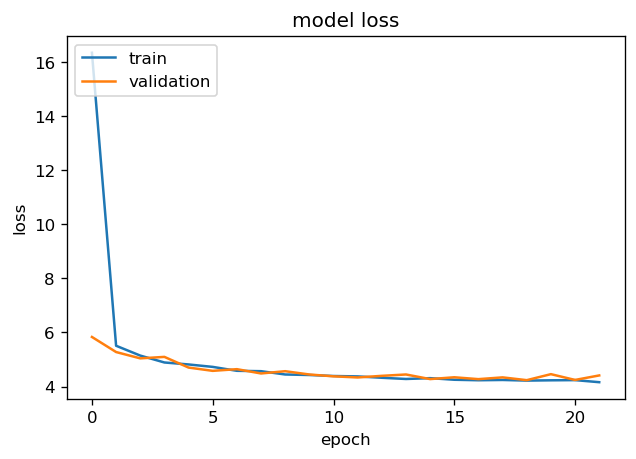

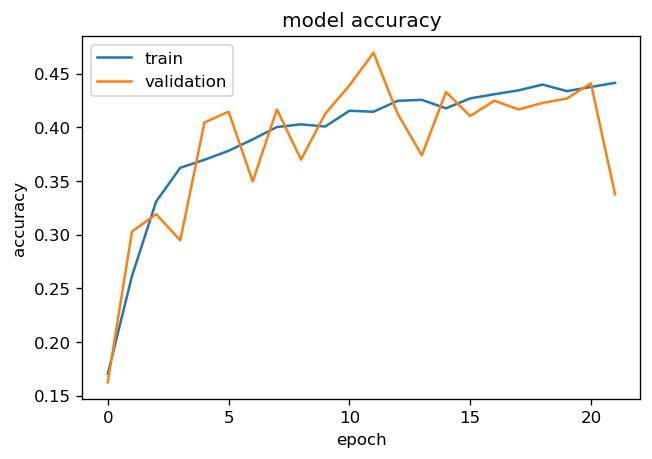

In [ ]:
# print ('Test loss:', round(score[0], 3))
# print ('Test accuracy:', round(score[1]*100, 2),'%')
plt.figure(dpi=120)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(dpi=120)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# "images" sizes
X_train = X_VGF_train.copy()
X_val = X_VGF_val.copy()
y_train = y_VGF_train.copy()
y_val = y_VGF_val.copy()

n1 = X_train.shape[1]
n2 = X_train.shape[2]

print("Las imágenes son de ",n1,"x",n2)

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

# normalizing the data to help with the training
# X_train /= 255
# X_test /= 255

# one-hot encoding using keras' numpy-related utilities
n_classes = 20
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_val = np_utils.to_categorical(y_val, n_classes)
# Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)


model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='leaky_relu', input_shape=(n1,n2,1)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
# model.add(Dropout(0.2))
# hidden layer
model.add(Dense(64, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
# model.add(BatchNormalization())
# model.add(Dense(64, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
# model.add(BatchNormalization())
# output layer
model.add(Dense(20, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model 

early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_val, Y_val)
            ,callbacks=[early_callback])

# score = model.evaluate(X_test, Y_test)

Las imágenes son de  10 x 100
Shape before one-hot encoding:  (4424,)
Shape after one-hot encoding:  (4424, 20)
Epoch 1/100
139/139 [==============================] - 5s 36ms/step - loss: 11.6278 - accuracy: 0.1474 - val_loss: 4.9256 - val_accuracy: 0.2439
Epoch 2/100
139/139 [==============================] - 5s 35ms/step - loss: 4.6914 - accuracy: 0.2507 - val_loss: 4.7600 - val_accuracy: 0.1850
Epoch 3/100
139/139 [==============================] - 5s 34ms/step - loss: 4.3559 - accuracy: 0.3083 - val_loss: 4.3124 - val_accuracy: 0.3150
Epoch 4/100
139/139 [==============================] - 5s 34ms/step - loss: 4.1785 - accuracy: 0.3373 - val_loss: 4.2508 - val_accuracy: 0.3028
Epoch 5/100
139/139 [==============================] - 5s 34ms/step - loss: 4.0138 - accuracy: 0.3696 - val_loss: 4.2545 - val_accuracy: 0.3252
Epoch 6/100
139/139 [==============================] - 5s 35ms/step - loss: 3.9563 - accuracy: 0.3795 - val_loss: 3.9330 - val_accuracy: 0.3882
Epoch 7/100
139/139 [==

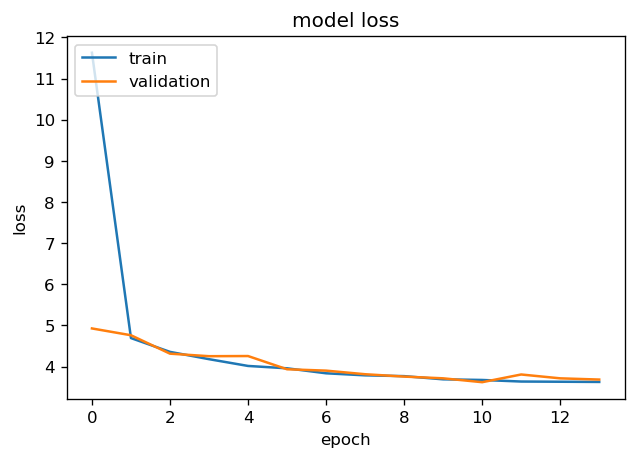

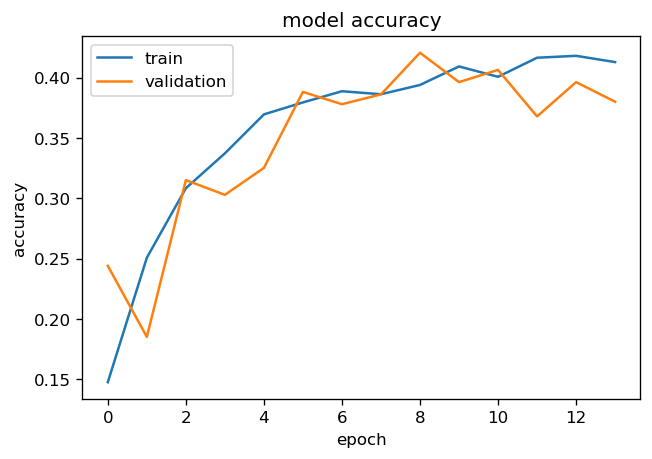

In [ ]:
# print ('Test loss:', round(score[0], 3))
# print ('Test accuracy:', round(score[1]*100, 2),'%')
plt.figure(dpi=120)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(dpi=120)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Lee matrices de entrenamiento (Top 5)

In [ ]:
X_VTR_train = np.load('X_VTR_train.npy', allow_pickle=True)
y_VTR_train = np.load('y_VTR_train.npy', allow_pickle=True)
X_VTR_val = np.load('X_VTR_val.npy', allow_pickle=True)
y_VTR_val = np.load('y_VTR_val.npy', allow_pickle=True)

X_VGF_train = np.load('X_VGF_train.npy', allow_pickle=True)
y_VGF_train = np.load('y_VGF_train.npy', allow_pickle=True)
X_VGF_val = np.load('X_VGF_val.npy', allow_pickle=True)
y_VGF_val = np.load('y_VGF_val.npy', allow_pickle=True)

In [ ]:
print(X_VTR_train.shape, y_VTR_train.shape)
print(X_VGF_train.shape, y_VGF_train.shape)

print(X_VTR_val.shape, y_VTR_val.shape)
print(X_VGF_val.shape, y_VGF_val.shape)

In [ ]:

X_VTR_train = X_VTR_train.reshape(X_VTR_train.shape[0], X_VTR_train.shape[1], X_VTR_train.shape[2], 1)[:,:5,:,:]
X_VTR_train = X_VTR_train.astype('float32')

X_VGF_train = X_VGF_train.reshape(X_VGF_train.shape[0], X_VGF_train.shape[1], X_VGF_train.shape[2], 1)[:,:5,:,:]
X_VGF_train = X_VGF_train.astype('float32')

X_VTR_val = X_VTR_val.reshape(X_VTR_val.shape[0], X_VTR_val.shape[1], X_VTR_val.shape[2], 1)[:,:5,:,:]
X_VTR_val = X_VTR_val.astype('float32')

X_VGF_val = X_VGF_val.reshape(X_VGF_val.shape[0], X_VGF_val.shape[1], X_VGF_val.shape[2], 1)[:,:5,:,:]
X_VGF_val = X_VGF_val.astype('float32')

print(X_VTR_train.shape)
print(y_VTR_train.shape)

print(X_VGF_train.shape)
print(y_VGF_train.shape)

# Clasificación usando CNN

In [ ]:
# "images" sizes
X_train = X_VTR_train.copy()
X_val = X_VTR_val.copy()
y_train = y_VTR_train.copy()
y_val = y_VTR_val.copy()

n1 = X_train.shape[1]
n2 = X_train.shape[2]

print("Las imágenes son de ",n1,"x",n2)

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

# normalizing the data to help with the training
# X_train /= 255
# X_test /= 255

# one-hot encoding using keras' numpy-related utilities
n_classes = 20
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_val = np_utils.to_categorical(y_val, n_classes)
# Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)


model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='leaky_relu', input_shape=(n1,n2,1)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
model.add(Dropout(0.2))
# hidden layer
model.add(Dense(100, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
model.add(BatchNormalization())
# model.add(Dense(64, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
# model.add(BatchNormalization())
# output layer
model.add(Dense(20, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model 

early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_val, Y_val)
            ,callbacks=[early_callback])

# score = model.evaluate(X_test, Y_test)

In [ ]:
# print ('Test loss:', round(score[0], 3))
# print ('Test accuracy:', round(score[1]*100, 2),'%')
plt.figure(dpi=120)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(dpi=120)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# "images" sizes
X_train = X_VGF_train.copy()
X_val = X_VGF_val.copy()
y_train = y_VGF_train.copy()
y_val = y_VGF_val.copy()

n1 = X_train.shape[1]
n2 = X_train.shape[2]

print("Las imágenes son de ",n1,"x",n2)

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

# normalizing the data to help with the training
# X_train /= 255
# X_test /= 255

# one-hot encoding using keras' numpy-related utilities
n_classes = 20
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_val = np_utils.to_categorical(y_val, n_classes)
# Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)


model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='leaky_relu', input_shape=(n1,n2,1)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
model.add(Dropout(0.2))
# hidden layer
model.add(Dense(128, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
model.add(BatchNormalization())
model.add(Dense(64, activation='leaky_relu'))
model.add(BatchNormalization())
# output layer
model.add(Dense(20, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model 

early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_val, Y_val)
            ,callbacks=[early_callback])

# score = model.evaluate(X_test, Y_test)

In [ ]:
# print ('Test loss:', round(score[0], 3))
# print ('Test accuracy:', round(score[1]*100, 2),'%')
plt.figure(dpi=120)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(dpi=120)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()